### Imports & Display Options

In [1]:
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 100

In [2]:
from matplotlib import pylab
import matplotlib.cm as cmap

In [3]:
import numpy as np
import feather
import re
from datetime import datetime
from itertools import cycle

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

In [5]:
from keras.utils import np_utils
from keras.layers import LSTM, Convolution1D, Flatten, Dropout, Dense, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.regularizers import l2
from keras.callbacks import TensorBoard, Callback
from keras.metrics import top_k_categorical_accuracy

Using TensorFlow backend.


### Import Data & Clean

In [ ]:
df = pd.read_csv('./BasicCompanyDataAsOneFile-2018-03-01.csv')
df.head()

In [ ]:
def clean_company_name(CompanyName):
    return CompanyName.str.replace('[".,()\-\']', ' ')\
        .str.replace('\s+', ' ').str.strip()\
        .str.replace('LIMITED', 'LTD')\
        .str.replace('INCORPORATED', 'INC')\
        .str.replace('([A-Z])LTD', '\\1 LTD')\
        .str.replace('(LTD|INC|PLC)', '')\
        .str.replace('\\b[A-Z0-9]\\b', '')

def clean(df, label):
    wdf = df[['CompanyName', label]]
    wdf['SICC'] = SICC = wdf[label].str.split(' - ').str[0]
    wdf = wdf[(SICC != '74990') & (SICC != '99999') & (SICC != '7499') & SICC.str.isnumeric()]
    wdf = wdf[wdf.CompanyName.str.count(' ') < 8]
    wdf.dropna(inplace=True)
    return wdf

In [ ]:
df['CompanyName'] = clean_company_name(df.CompanyName)

In [ ]:
len(df)

In [ ]:
wdf = pd.concat([clean(df, 'SICCode.SicText_1'),
                 clean(df, 'SICCode.SicText_2'),
                 clean(df, 'SICCode.SicText_3'),
                 clean(df, 'SICCode.SicText_4')])
len(wdf)

In [55]:
wdf[wdf.CompanyName.str.contains('!')].sample(20)

,CompanyName,SICC,Industry,OrigIndustry
3144100,OH MATRON!,90020,900,900
2426640,SO! ENTERTAINMENT,59200,592,592
2925092,YO! SUSHI UK,56101,561,561
3188077,SH!TBOOK,62090,6209,620
654720,CRAIG! RECRUITS,78300,783,783
911662,EUREKA! DESIGN CONSULTANTS,73110,731,731
2092825,PREST!GE,47910,4791,479
352228,BIKERIGHT!,85590,855,855
2975899,BAILAME!,90020,900,900
3145723,ONIT! PR,82190,821,821


### Remove Unknown Names

In [39]:
wdf['WordSum'] = wdf.CompanyName.apply(words_below_rank(35000))
(wdf.WordSum == 0).sum()

204632

In [60]:
# Remove super short names
(wdf.CompanyName.str.len() < 6).sum()

15406

In [41]:
wdf.sample(50)

,CompanyName,SICC,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,WordSum
254144,APEXIA CONSULTING,82990,82990 - Other business support service activit...,None,None,None,3
3339699,THE PLAYWRITE GROUP,46900,46900 - Non-specialised wholesale trade,None,None,None,3
4147519,KINDLEGRADE,68320,None,None,68320 - Management of real estate on a fee or ...,None,2
1192704,FANCHY DESIGN GROUP,74100,74100 - specialised design activities,None,None,None,3
466668,BLH UK,84230,84230 - Justice and judicial activities,None,None,None,1
2685516,PUPILASSET,63110,"63110 - Data processing, hosting and related a...",None,None,None,2
2046189,LUMSDEN SUPPORT,82990,82990 - Other business support service activit...,None,None,None,1
948693,DESIGNA BLINDS,47190,47190 - Other retail sale in non-specialised s...,None,None,None,1
2632615,PRAISE MANPOWER SERVICES,86101,86101 - Hospital activities,None,None,None,3
1225059,FIRE MEDIA,60100,60100 - Radio broadcasting,None,None,None,2


In [44]:
custom_tokenize2('musicality')

[74699]

In [42]:
wdf[wdf.WordSum == 0].sample(50)

,CompanyName,SICC,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,WordSum
3026722,SIRASA,47300,47300 - Retail sale of automotive fuel in spec...,None,None,None,0
1456167,CHEMIE PELZER,29320,29320 - Manufacture of other parts and accesso...,None,None,None,0
4078392,XOYA,62012,None,62012 - Business and domestic software develop...,None,None,0
701339,CHORLEY RVN,75000,75000 - Veterinary activities,None,None,None,0
3698295,YUSHAN,62090,62090 - Other information technology service a...,None,None,None,0
2432254,OHANA AYH,70229,70229 - Management consultancy activities othe...,None,None,None,0
4090424,ANIMESH,74100,None,None,74100 - specialised design activities,None,0
2252290,MOGI,68209,68209 - Other letting and operating of own or ...,None,None,None,0
3321883,THE L8 BLOOMERS,63910,63910 - News agency activities,None,None,None,0
653579,CEDARS,98000,98000 - Residents property management,None,None,None,0


In [ ]:
wdf = wdf[(wdf.WordSum > 0) & (wdf.CompanyName.str.len() > 6) & (wdf.SICC.str.len() == 5)]
len(wdf)

In [ ]:
# Remove company names that are all numbers
wdf = wdf[~wdf.CompanyName.str.match('^[0-9\\s]+$')]
len(wdf)

### Feature Engineering

In [53]:
hard_to_classify_set = {"829", "479", "960", "329", "639", "661", "702"}
grouped_classify_set = {"01", "02", "03", "09", "10", "13", "35", "38",
                        "45", "46", "50", "55", "56", "61", "78", "79", "80", "85", "86", "87", "88"}
super_group = {"2"}
def merge_split_classes(value):
    if value[0] in super_group:
        return value[0]
    elif value[:2] in grouped_classify_set:
        return value[:2]
    elif value[:3] in hard_to_classify_set:
        return value[:4]
    else:
        return value[:3]

In [54]:
# Split some hard to classify classes out
wdf['Industry'] = wdf.SICC.apply(merge_split_classes)
wdf.sample(50)

,CompanyName,SICC,Industry,OrigIndustry
1783936,NJ ACCOUNTANTS,69202,692,692
2897319,FUTURE CREATIVE SOLUTIONS,62020,620,620
1839879,ONJENU,74100,741,741
1636684,MEG KING BUSINESS SERVICES,69202,692,692
2195454,SARAH CARES BATH,88100,88,881
2295403,SMIZZLECORP INDUSTRIES,62012,620,620
761292,DR CONSTRUCTION NFK,41100,411,411
2660239,VICEROY MANSIONS RTM COMPANY,98000,980,980
2262632,SILVER STAGE EVENT STRUCTURES,77390,773,773
1737106,HARKER CONSTRUCTION,41201,412,412


In [55]:
wdf[wdf['Industry']=='87']

,CompanyName,SICC,Industry,OrigIndustry
191,DE NOVO CARE,87900,87,879
949,RECREATION ROAD MANAGEMENT COMPANY,87900,87,879
1278,STAR CARE,87300,87,873
4354,121 CARE SUPPLIES,87900,87,879
4404,121 HEALTH SOLUTIONS,87100,87,871
4527,123 CARE SOLUTIONS,87300,87,873
4794,127 UPPER TULSE HILL RTM COMPANY,87900,87,879
4895,12STONES,87200,87,872
4963,13 BROTHERS,87100,87,871
7334,16 PLUS TEAM,87900,87,879


In [57]:
# These class is not possible to predict, a bunch of misc.
wdf = wdf[wdf.Industry != '8299']  # Other business activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '9609']  # Other service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.Industry != '4618']  # Sales of other products
print(len(wdf))
wdf = wdf[wdf.Industry != '4619']  # Sales of variety of goods
print(len(wdf))
wdf = wdf[wdf.Industry != '559']  # Other accomodations
print(len(wdf))
wdf = wdf[wdf.Industry != '332']  # Industrial machinery
print(len(wdf))
wdf = wdf[wdf.Industry != '682']  # Renting and leasing real estate
print(len(wdf))
wdf = wdf[wdf.SICC != '74909']   # Other professional, scientific, technical activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '79909']   # Other reservation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '63990']   # Other infomation service activities (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '47990']   # Other retail sales
print(len(wdf))
wdf = wdf[wdf.SICC != '68209']   # Other letting operating real estate (n.e.c)
print(len(wdf))
wdf = wdf[wdf.SICC != '66190']   # Activities auxiliary financial intermediation (n.e.c)
print(len(wdf))

3766230
3628296
3621491
3613690
3603217
3597829
3454743
3374256
3370077
3343987
3316492
3316492
3307877


In [68]:
wdf[wdf.CompanyName.str.strip(' *&^/\?!@#$%^*()~`|{}-+:;<>,.0123456789').str.len() < 6]

,CompanyName,SICC,Industry,OrigIndustry
0,!NNOV8,62090,6209,620
26,COOL,43220,432,432
88,& GB,42990,429,429
99,RINGS,46900,469,469
164,SALON,96020,9602,960
170,ZUZIA,49410,494,494
171,$$ DEALS $$,47910,4791,479
173,$10 CHIMP,70210,7021,702
179,& BLANC,47710,477,477
184,& NEW,46470,4647,464


In [69]:
wdf = wdf[wdf.CompanyName.str.strip(' *&^/\?!@#$%^*()~`|{}-+:;<>,.0123456789').str.len() > 5]

In [72]:
wdf.sample(50)

,CompanyName,SICC,Industry,OrigIndustry
3623977,WHYTES OF MONIFIETH,43220,432,432
2194222,METALDANCE,33190,331,331
434989,BGAM HOTELS SH,64209,6420,642
2000814,LIVINGCITY CO UK,62090,6209,620
1156056,EVALUCOM CONSULTING,62012,6201,620
2151764,MAYFIELD SCHOOL SERVICES,47710,477,477
1033574,DW PERFORMANCE,45200,452,452
2214180,MIGHTY GOOD UNDIES UK,14141,141,141
4087673,AJAY KUMAR ADVOCATE,69109,691,691
820627,COX & HALL,43220,432,432


### Check for Class Imbalance

In [11]:
def plot_frequency(df, feature, top=50):
    classes = df.groupby([feature]).CompanyName.count().sort_values(ascending=False)
    print('AVG: ', classes.mean())
    return classes.head(top).plot(kind='bar', figsize=(10, 3))

AVG:  18584.827586206895


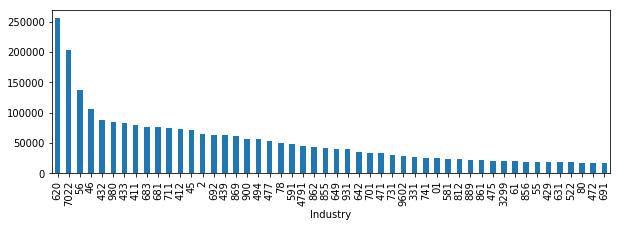

In [12]:
plot_frequency(wdf, 'Industry')

AVG:  4522.741258741259


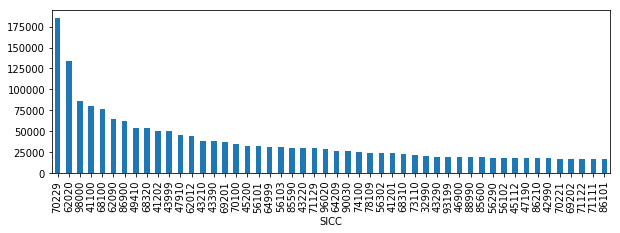

In [57]:
plot_frequency(wdf, 'SICC')

In [61]:
min_class_count = 500
classes = wdf.groupby(['Industry']).count().sort_values('CompanyName', ascending=False)
print(' Classes below %s samples: %s/%s' % (min_class_count, (classes.CompanyName < min_class_count).sum(), len(classes.CompanyName)))

 Classes below 500 samples: 20/163


In [62]:
classes[classes.CompanyName < min_class_count].head()

,CompanyName,SICC,OrigIndustry
Industry,,,
161,474,474,474
492,443,443,443
302,418,418,418
072,398,398,398
152,358,358,358


In [63]:
classes[classes.CompanyName < min_class_count].sum()

CompanyName     4250
SICC            4250
OrigIndustry    4250
dtype: int64

In [64]:
# Remove classes with low count
to_replace = classes[classes.CompanyName < min_class_count].index
wdf['Industry'] = wdf['Industry'].replace(to_replace, '0')
# Remove unknown data
wdf = wdf[wdf['Industry'] != '0']
len(wdf)

3229510

### Resample Data

AVG:  10779.2


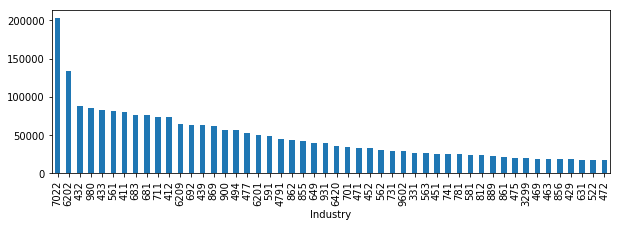

In [83]:
plot_frequency(wdf, 'Industry')

AVG:  4522.741258741259


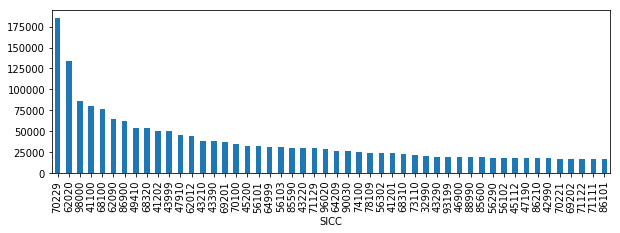

In [84]:
plot_frequency(wdf, 'SICC')

In [57]:
def resample_classes(df, groupby, samples):
    classes = wdf.groupby([groupby]).CompanyName.count()
    freqs = dict(samples/classes)
    freq = df[groupby].map(freqs)
    np.random.seed(42)
    criteria = np.random.rand(len(df)) < freq
    return df[criteria]

In [58]:
rwdf = resample_classes(wdf, 'Industry', 7500)

AVG:  4643.239263803681


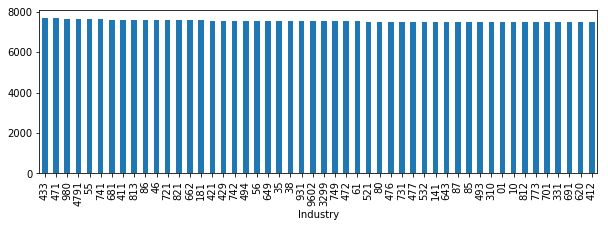

In [59]:
plot_frequency(rwdf, 'Industry')

AVG:  1058.5286713286714


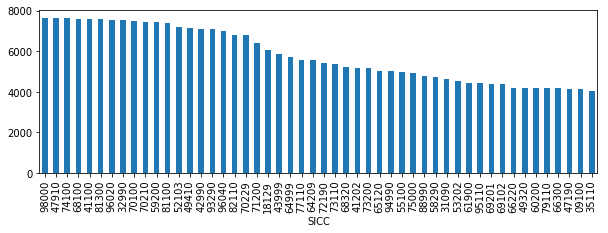

In [60]:
plot_frequency(rwdf, 'SICC')

### Pickle Working Set

In [ ]:
feather.write_dataframedata(df, 'df.feather')

In [ ]:
feather.write_dataframe(wdf, 'wdf4ms.feather')  # SIC Text 1, 2, 3, 4 stacked

In [47]:
feather.write_dataframe(wdf, 'wdf4msk.feather')  # Unknown names removed

In [76]:
feather.write_dataframe(wdf, 'wdf4mskf.feather')  # Feature engineered

In [56]:
feather.write_dataframe(wdf, 'wdf4mskfr.feather')  # Resampled classes

In [6]:
wdf = feather.read_dataframe('wdf4mskfr.feather')
wdf.head()

,CompanyName,SICC,Industry,OrigIndustry
0,!NSPIRED,70229,7022,702
1,!NVERTD DESIGNS,58190,581,581
2,!OBAC UK,70229,7022,702
3,243 RUGBY ROAD MANAGEMENT COMPANY,98000,980,980
4,309 WEST END LANE MANAGEMENT,98000,980,980


### Label Encoding

In [67]:
industry_encoder = LabelEncoder()
industry_encoder.fit(rwdf['Industry'])
encoded_industry = industry_encoder.transform(rwdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

(756848, 163)

In [68]:
num_industries = industry_labels.shape[1]

### Text Encoding

In [19]:
def load_glove_embeddings(fp, embedding_dim, include_empty_char=True):
    """
    Loads pre-trained word embeddings (GloVe embeddings)
        Inputs: - fp: filepath of pre-trained glove embeddings
                - embedding_dim: dimension of each vector embedding
                - generate_matrix: whether to generate an embedding matrix
        Outputs:
                - word2coefs: Dictionary. Word to its corresponding coefficients
                - word2index: Dictionary. Word to word-index
                - embedding_matrix: Embedding matrix for Keras Embedding layer
    """
    # First, build the "word2coefs" and "word2index"
    word2coefs = {} # word to its corresponding coefficients
    word2index = {} # word to word-index
    with open(fp) as f:
        for idx, line in enumerate(f):
            try:
                data = [x.strip().lower() for x in line.split()]
                word = data[0]
                coefs = np.asarray(data[1:embedding_dim+1], dtype='float32')
                word2coefs[word] = coefs
                if word not in word2index:
                    word2index[word] = len(word2index)
            except Exception as e:
                print('Exception occurred in `load_glove_embeddings`:', e)
                continue
        # End of for loop.
    # End of with open
    if include_empty_char:
        word2index[''] = len(word2index)
    # Second, build the "embedding_matrix"
    # Words not found in embedding index will be all-zeros. Hence, the "+1".
    vocab_size = len(word2coefs)+1 if include_empty_char else len(word2coefs)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in word2index.items():
        embedding_vec = word2coefs.get(word)
        if embedding_vec is not None and embedding_vec.shape[0]==embedding_dim:
            embedding_matrix[idx] = np.asarray(embedding_vec)
    # return word2coefs, word2index, embedding_matrix
    return word2index, np.asarray(embedding_matrix)

In [20]:
word2index, embedding_matrix = load_glove_embeddings('glove.6B/glove.6B.200d.txt', embedding_dim=200)

In [ ]:
def custom_tokenize(d):
    return [word2index.get(re.sub(r'[^\w\s]','',w).lower(), 0) for w in d.split()]

In [21]:
def custom_tokenize2(d):
    tokens = []
    words = d.split()
    for word in words:
        word = re.sub(r'[^\w\s]','',word).lower()
        if word in word2index:
            tokens.append(word2index[word])
        else:
            for w in split_compound_words(word, word2index):
                if len(w) == 1:
                    tokens.append(0)
                else:
                    tokens.append(word2index.get(w, 0))
    return tokens

def split_compound_words(word, corpus):
    result = [word]
    word = word.strip('0123456789!?,. ')
    min_score = 2e5
    max_threshold = 3e4
    min_threshold = 250
    for x in range(1, len(word)+1):
        head, tail = word[:x], word[x:]
        head_score = corpus.get(head, 2e5/2) + max(0, -len(head)*20000 + 60000)
        tail_score = corpus.get(tail, 2e5/2) + max(0, -len(tail)*20000 + 60000)
        if ((min_threshold < head_score < max_threshold) or
            (min_threshold < tail_score < max_threshold)):
            if (head_score + tail_score) < min_score:
                result = [head, tail]
                min_score = head_score + tail_score
    return result

In [22]:
print(split_compound_words('communitech', word2index))
print(split_compound_words('biceppower', word2index))
print(split_compound_words('appleworks', word2index))
print(split_compound_words('tmobile', word2index))
print(split_compound_words('northstar', word2index))
print(split_compound_words('griscware', word2index))
print(split_compound_words('windmobile', word2index))
print(split_compound_words('dreamworks', word2index))
print(split_compound_words('quackdoctor', word2index))
print(split_compound_words('fontof', word2index))

['communi', 'tech']
['bicep', 'power']
['apple', 'works']
['t', 'mobile']
['north', 'star']
['grisc', 'ware']
['wind', 'mobile']
['dream', 'works']
['quack', 'doctor']
['font', 'of']


In [10]:
def words_below_rank(rank):
    def count_words_below_rank(d):
        return sum(1 for r in custom_tokenize2(d) if r > 0 and r < rank)
    return count_words_below_rank

In [24]:
vocab_size, embedding_dim = embedding_matrix.shape
maxlen = 10
print(custom_tokenize2('Rhinoshield'))
print(custom_tokenize2('21039'))
print(custom_tokenize2('what is this, an apple ltd?'))
vocab_size, embedding_dim

[21921, 5728]
[0]
[102, 14, 37, 29, 3292, 8196]


(400001, 200)

In [65]:
encoded_company_names = [custom_tokenize2(d) for d in rwdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [69]:
# Sanity check
len(encoded_company_names), len(industry_labels)

(756848, 756848)

### Train/Test Split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    encoded_company_names, industry_labels, test_size=0.15, random_state=42)
y_train.shape

(643320, 163)

### Model

In [71]:
weight_decay = 1e-4
num_filters = 128
n2 = 256
n3 = 128
pool_size = 2
window_size = 3
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen,
                            weights=[embedding_matrix], trainable=False)
top3 = lambda x, y: top_k_categorical_accuracy(x, y, k=3)
top3.__name__ = 'top3'

model = Sequential()
model.add(embedding_layer)
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size))
model.add(Convolution1D(num_filters, window_size, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
#model.add(Dense(n2, activation='relu', kernel_regularizer=l2(weight_decay)))
#model.add(Dropout(0.2))
model.add(Dense(n3, activation='relu', kernel_regularizer=l2(weight_decay)))
# model.add(Dropout(0.2))
model.add(Dense(num_industries, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', top3])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 200)           80000200  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           76928     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 128)           49280     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 163)               21027     
Total para

### ROC AUC Metric

In [72]:
class ROCCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x, self.y = training_data
        self.x_val, self.y_val = validation_data

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

### Hook up Tensorboard

`tensorboard --logdir='tmp'`

In [73]:
date_suffix = str(datetime.now()).replace(':', '-').split('.')[0]
temp_folder = 'tmp/GloVe%s-fd%s-industry-resmpl-cnn3x%s-%s-gpool-compound-%s' % (
    embedding_dim, num_industries, num_filters, n3, date_suffix)
temp_folder

'tmp/GloVe200-fd163-industry-resmpl-cnn3x128-128-gpool-compound-2018-03-29 15-37-11'

### Train Model

In [74]:
callbacks = [TensorBoard(log_dir=temp_folder)]
#callbacks.append(ROCCallback((X_train, y_train), (X_test, y_test)))
model.fit(
    X_train, y_train, epochs=12, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=callbacks)

Train on 643320 samples, validate on 113528 samples
Epoch 1/12
643320/643320 [==============================] - 92s 143us/step - loss: 3.6008 - acc: 0.2178 - top3: 0.3653 - val_loss: 3.3043 - val_acc: 0.2772 - val_top3: 0.4376
Epoch 2/12
643320/643320 [==============================] - 89s 139us/step - loss: 3.3707 - acc: 0.2617 - top3: 0.4193 - val_loss: 3.2572 - val_acc: 0.2844 - val_top3: 0.4477
Epoch 3/12
643320/643320 [==============================] - 90s 140us/step - loss: 3.3217 - acc: 0.2711 - top3: 0.4296 - val_loss: 3.2508 - val_acc: 0.2853 - val_top3: 0.4489
Epoch 4/12
643320/643320 [==============================] - 89s 139us/step - loss: 3.2967 - acc: 0.2751 - top3: 0.4349 - val_loss: 3.2254 - val_acc: 0.2874 - val_top3: 0.4549
Epoch 5/12
643320/643320 [==============================] - 91s 142us/step - loss: 3.2807 - acc: 0.2782 - top3: 0.4379 - val_loss: 3.2325 - val_acc: 0.2884 - val_top3: 0.4529
Epoch 6/12
643320/643320 [==============================] - 93s 145us/ste

### Testing/Validation

In [77]:
loss, accuracy, top3 = model.evaluate(X_test, y_test)
accuracy

113528/113528 [==============================] - 7s 65us/step


0.29407723204743141

In [78]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(X_test)
y_labels.shape, y_pred.shape
y_scores = model.predict(X_test)
cm = confusion_matrix(y_pred, y_labels)

In [79]:
print('Verifying accuracy', (y_labels==y_pred).sum()/len(y_pred))

Verifying accuracy 0.294077232048


In [80]:
def plot_confusion_matrix(cm, encoder, xlim=None, ylim=None):
    pylab.figure(figsize=(18,18))
    cm = cm/cm.sum(axis=0)
    dim, _ =cm.shape
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=0.5)
    ax = pylab.gca()
    ax.set_xticks(range(dim))
    ax.set_xticklabels(encoder.inverse_transform(pd.Series(range(dim))), rotation='vertical')
    ax.set_yticks(range(dim))
    ax.set_yticklabels(encoder.inverse_transform(pd.Series(range(dim))))
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    pylab.show()

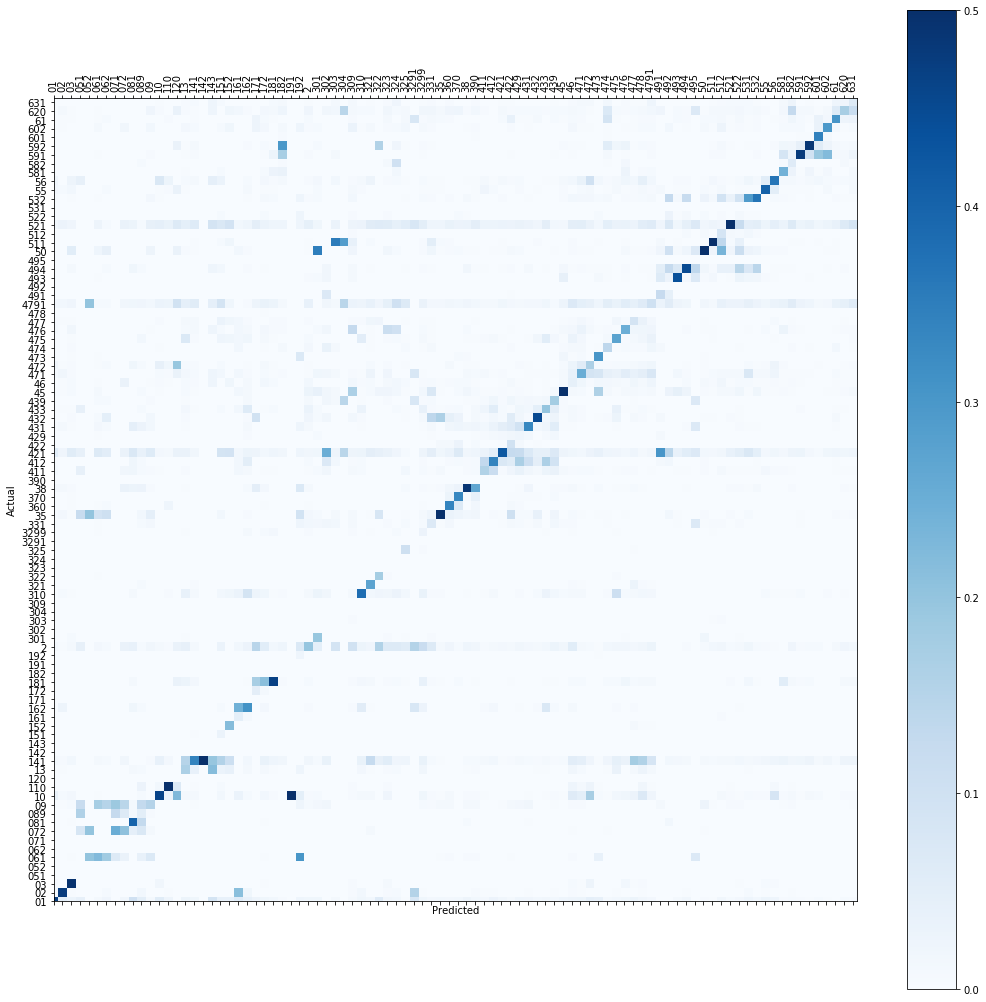

In [81]:
plot_confusion_matrix(cm, industry_encoder, xlim=[0, num_industries/2+10], ylim=[0, num_industries/2+10])

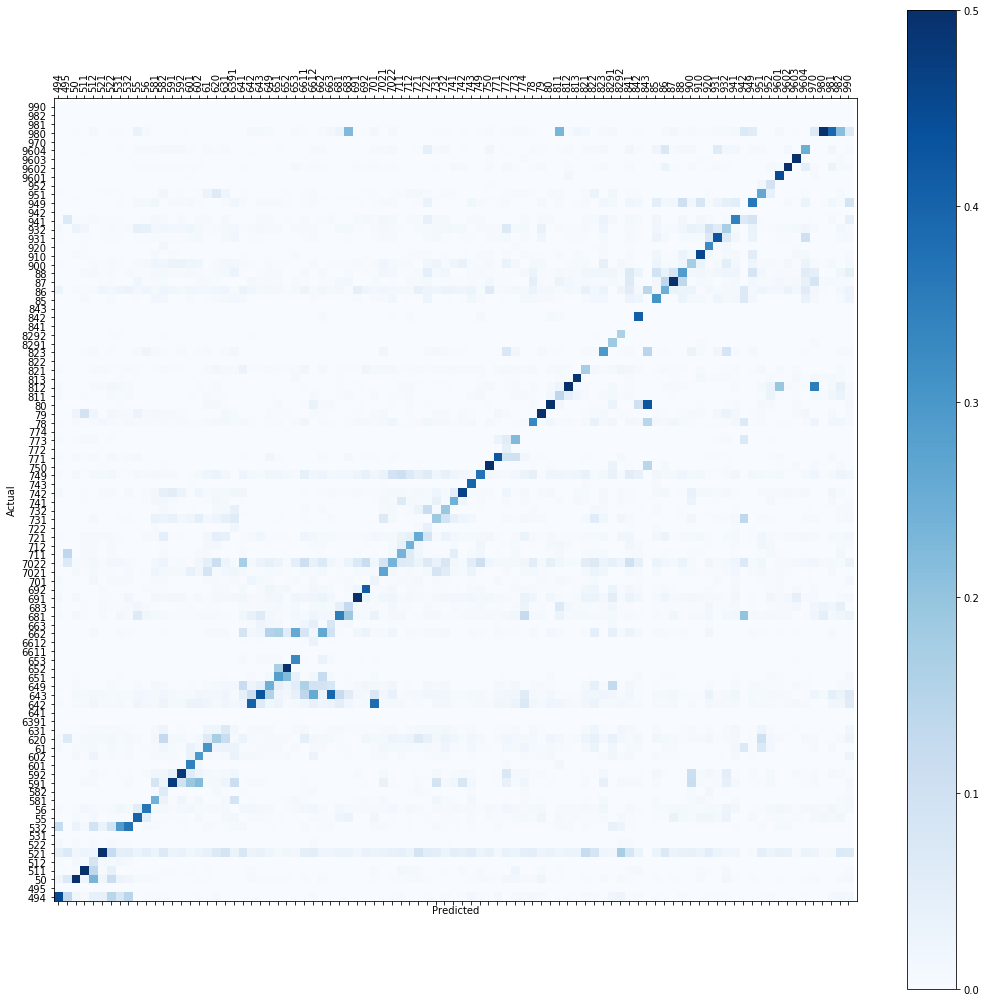

In [82]:
plot_confusion_matrix(cm, industry_encoder, xlim=[num_industries/2-10, num_industries], ylim=[num_industries/2-10, num_industries])

In [83]:
def acc_per_class(cm, encoder):
    cm_scaled = cm/cm.sum(axis=0)
    cm_offdiag_mask = np.ones(cm.shape)
    np.fill_diagonal(cm_offdiag_mask, 0)
    acc = pd.Series(np.diag(cm_scaled))
    acc = acc.reset_index()
    acc['acc'] = acc[0]
    acc['cls'] = encoder.inverse_transform(acc.index)
    acc['total'] = cm.sum(axis=0)
    acc['fcls'] = encoder.inverse_transform(np.argmax(cm*cm_offdiag_mask, axis=0))
    return acc[['cls', 'acc', 'total', 'fcls']].set_index('cls').sort_values('acc', ascending=False)

In [84]:
acc_per_class(cm, industry_encoder)

,acc,total,fcls
cls,,,
980,0.818182,1133,681
110,0.630081,738,521
9602,0.615662,1111,141
511,0.590000,400,79
79,0.566929,1143,932
750,0.561404,741,86
9603,0.542005,369,01
652,0.530504,377,651
521,0.527354,1115,421


In [85]:
def bubble_plot(cm, encoder, xlim=None, ylim=None):
    df = acc_per_class(cm, encoder).reset_index()
    df['ind'] = encoder.transform(df['cls'])
    df['find'] = encoder.transform(df['fcls'])
    ax = pylab.gca()
    df.plot.scatter(ax=ax, x='find', y='ind', s=df['total']*0.5, c='acc',
                         figsize=(18, 15), cmap=cmap.get_cmap('Spectral'))
    dim = len(df)
    cls = encoder.inverse_transform(pd.Series(range(dim)))
    ax.set_xticks(range(dim))
    ax.set_xticklabels(cls, rotation='vertical')
    ax.set_yticks(range(dim))
    ax.set_yticklabels(cls)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    pylab.xlabel('Predicted Class')
    pylab.ylabel('Actual Class')
    pylab.gcf().tight_layout()
    for i, txt in enumerate(df['cls']):
        ax.annotate('%s, %s' % (df.fcls.iat[i], df.cls.iat[i]), (df.find.iat[i], df.ind.iat[i]))

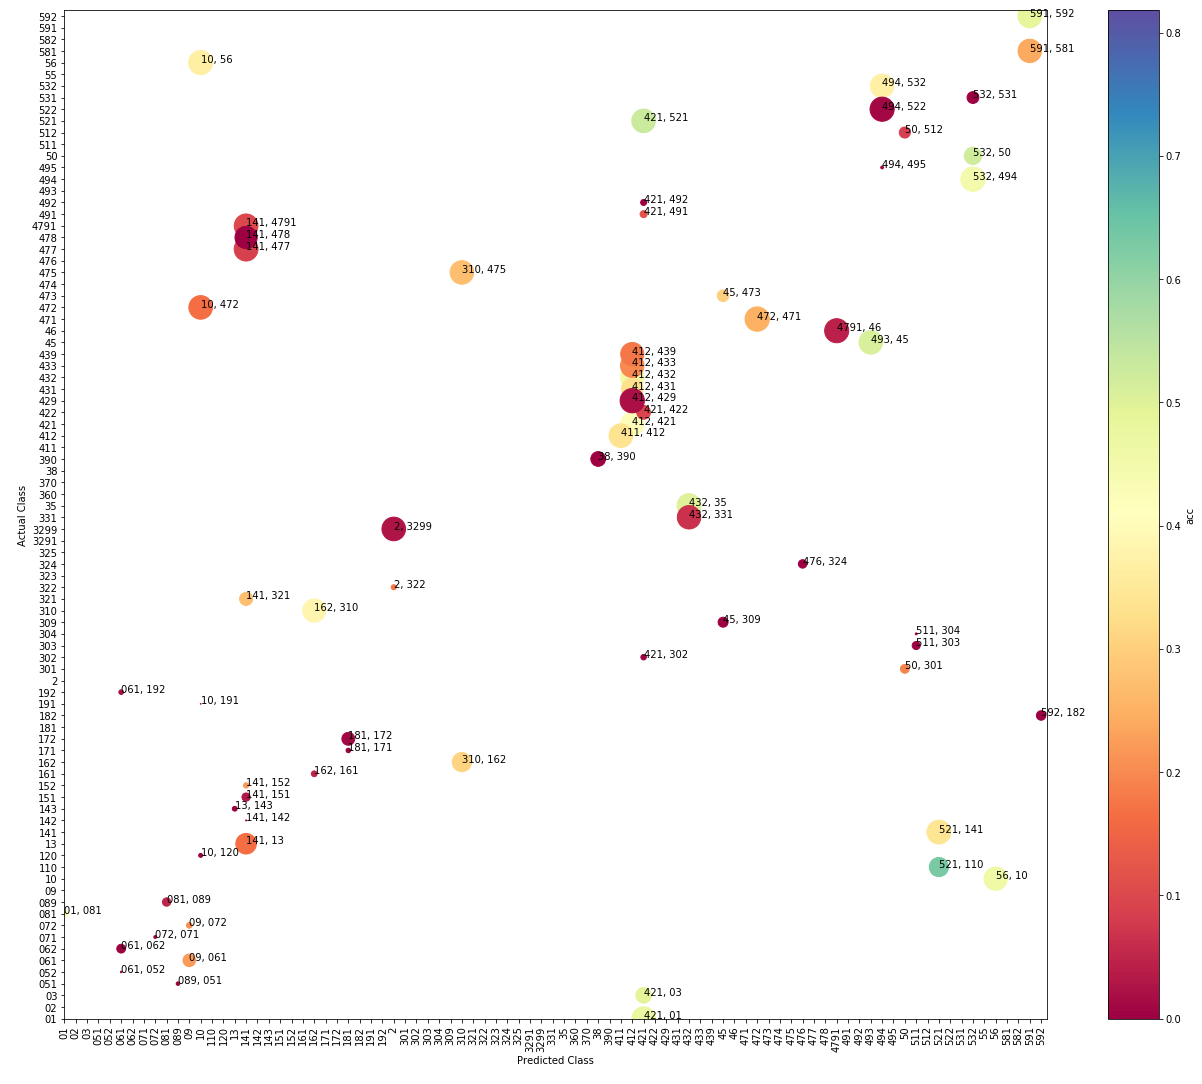

In [86]:
bubble_plot(cm, industry_encoder, [0, num_industries/2+5], [0, num_industries/2+5])

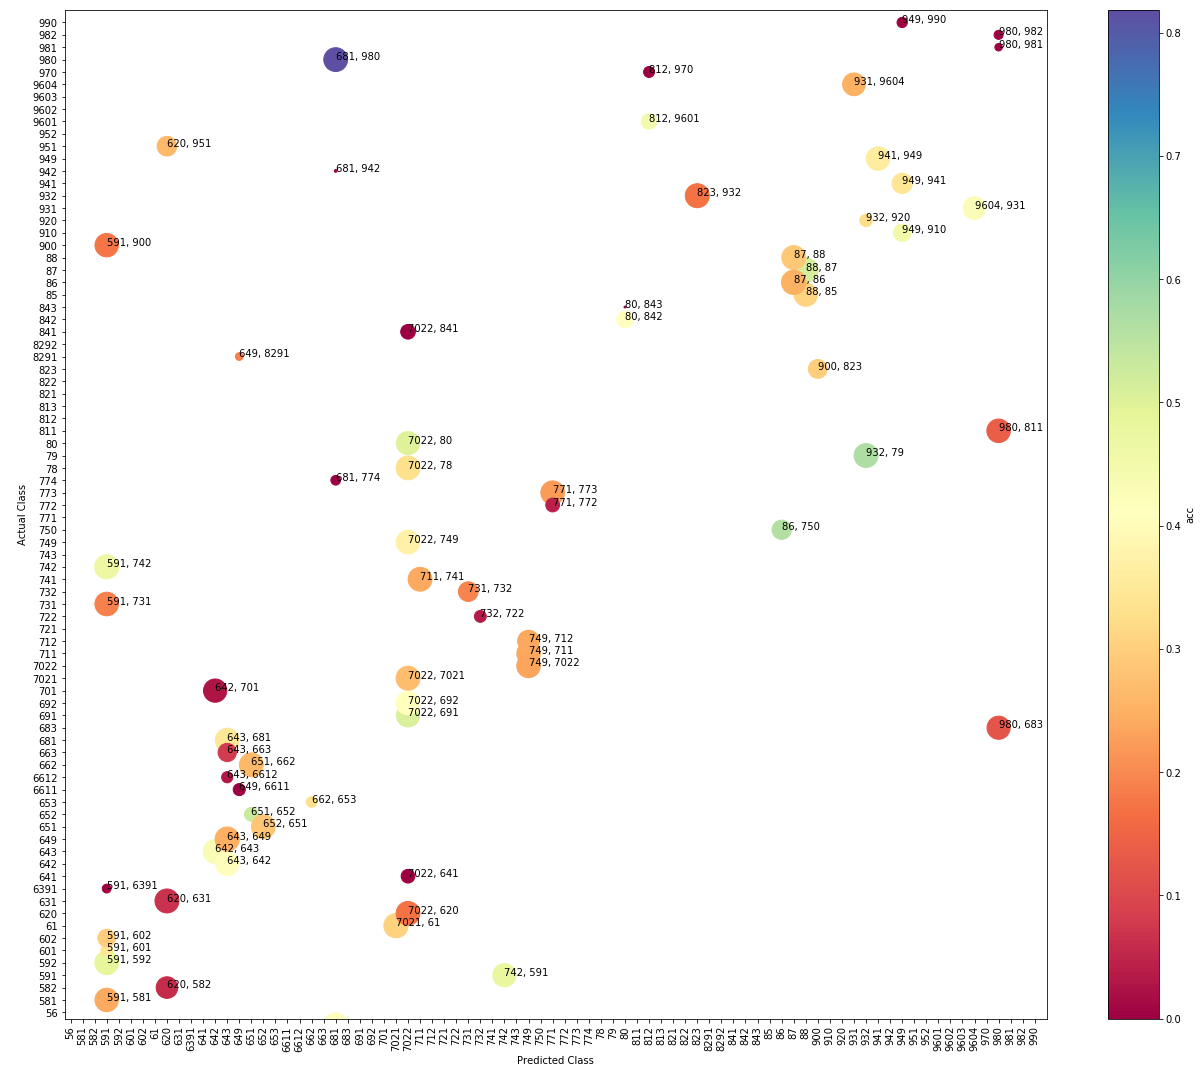

In [87]:
bubble_plot(cm, industry_encoder, [num_industries/2, num_industries], [num_industries/2, num_industries])

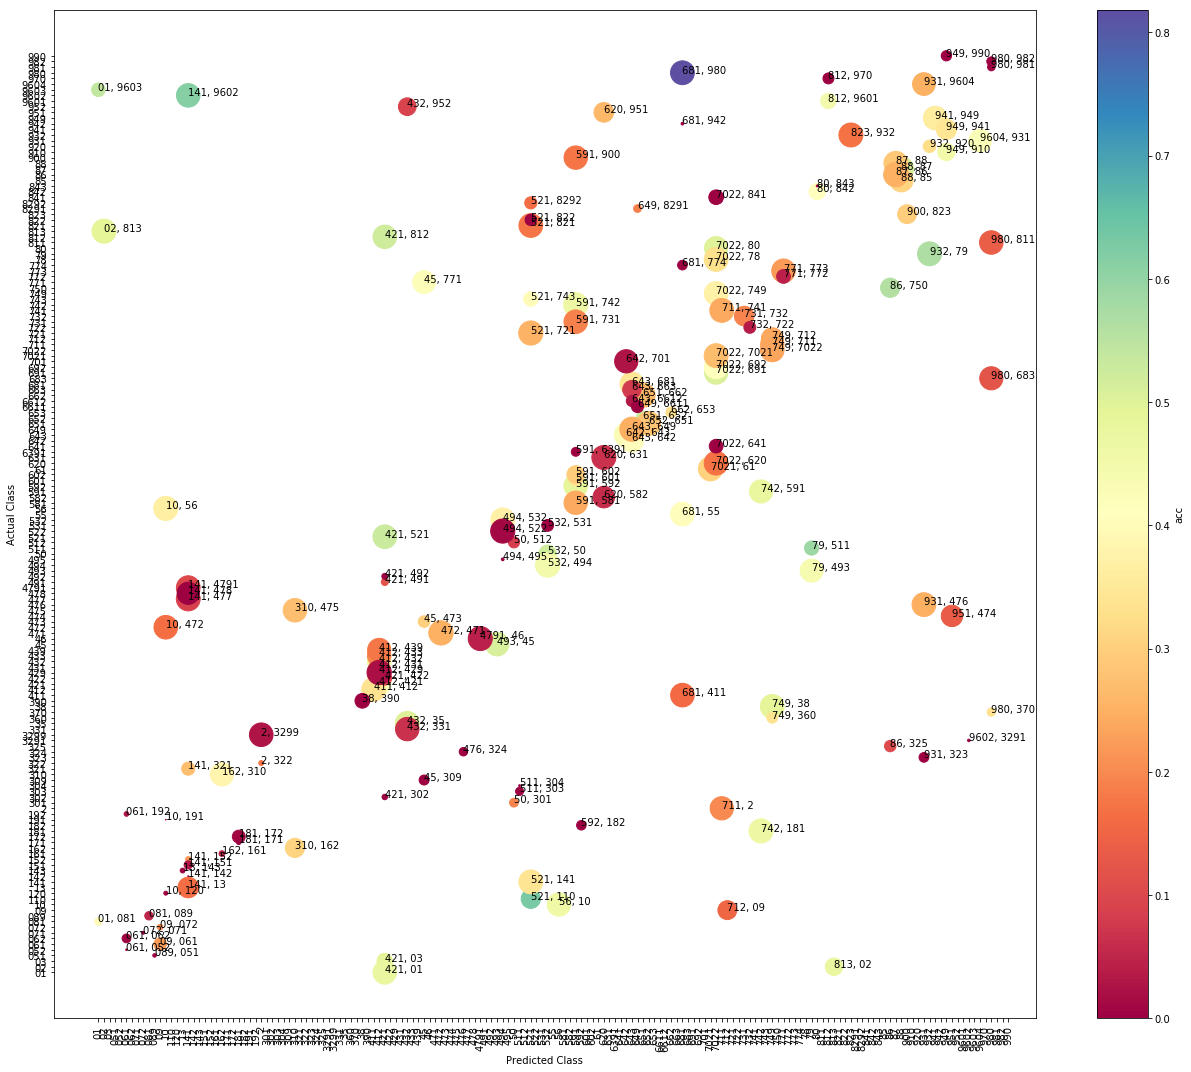

In [88]:
bubble_plot(cm, industry_encoder)

### ROC Evaluation

In [89]:
def plot_roc(y_test, y_score, encoder, auc_lim=(0, 1)):
    # Compute ROC curve and area for each class
    print('ROC AUC Score: %s' % roc_auc_score(y_test, y_score))
    lw = 2
    n_classes = y_test.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = pylab.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(8)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'crimson', 'navy',
                    'darksalmon', 'cadetblue', 'deeppink', 'darkolivegreen', 'fuchsia'])
    sorted_classes = sorted(range(n_classes), key=lambda i: roc_auc[i])
    for i, color in zip(sorted_classes, colors):
        if auc_lim[0] <= roc_auc[i] <= auc_lim[1]:
            ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                    ''.format(encoder.inverse_transform(i), roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.05])
    pylab.xlabel('False Positive Rate')
    pylab.ylabel('True Positive Rate')
    ax.legend(loc="lower left", bbox_to_anchor=(0.0, 1.01), ncol=4, frameon=False)
    pylab.show()

In [ ]:
plot_roc(y_test, y_scores, industry_encoder, auc_lim=(0, 0.8))

ROC AUC Score: 0.819567704172


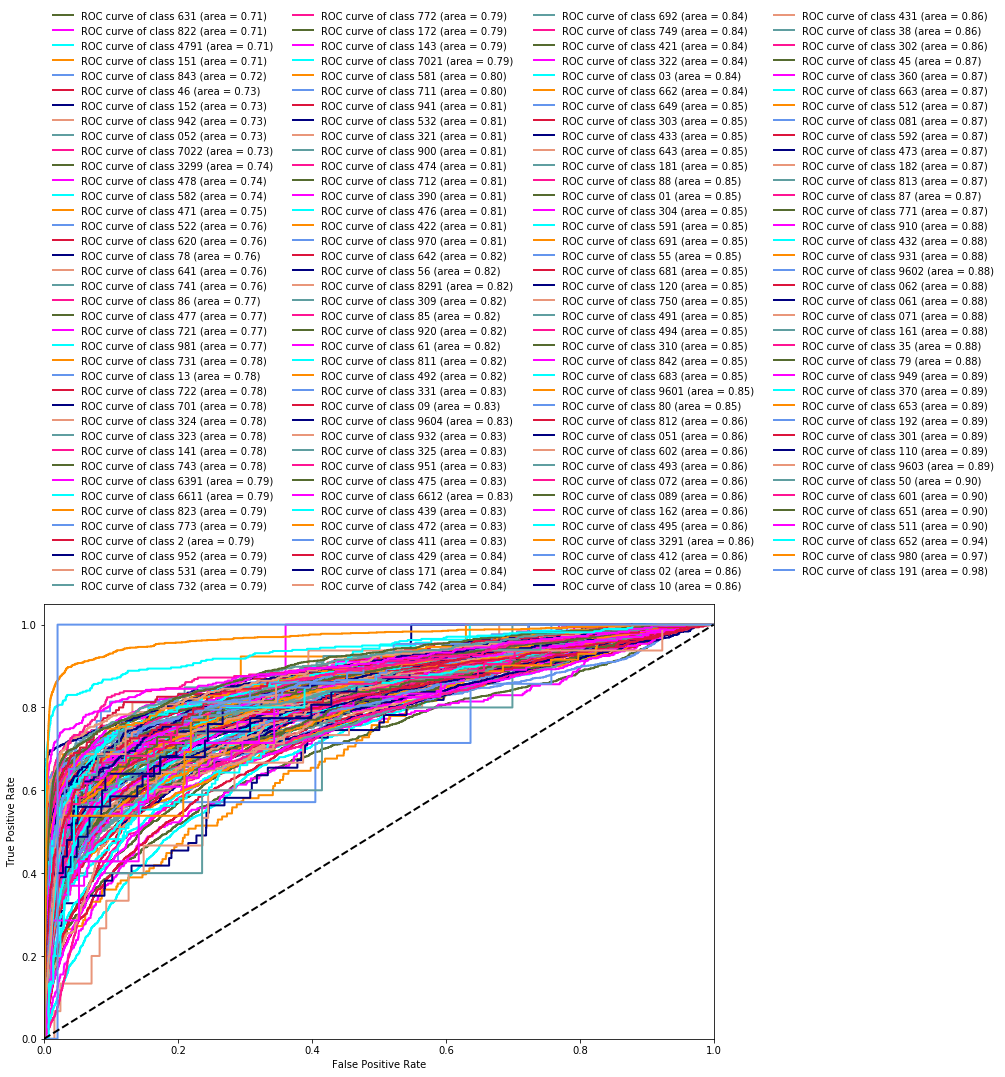

In [92]:
plot_roc(y_test, y_scores, industry_encoder, auc_lim=(0.8, 1))

### Test with Original Sampling

In [ ]:
industry_encoder = LabelEncoder()
industry_encoder.fit(wdf['Industry'])
encoded_industry = industry_encoder.transform(wdf['Industry'])
industry_labels = np_utils.to_categorical(encoded_industry)
industry_labels.shape

In [ ]:
encoded_company_names = [custom_tokenize(d) for d in wdf.CompanyName]
encoded_company_names = [d for d in encoded_company_names]
encoded_company_names = pad_sequences(encoded_company_names, maxlen=maxlen, padding='post')

In [ ]:
# Sanity check
len(encoded_company_names), len(industry_labels)

In [ ]:
y_pred_score = model.predict(encoded_company_names)

In [ ]:
industry_labels.shape, y_pred_score.shape

In [ ]:
# Top K accuracy
print('Top1: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=1))
print('Top3: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=3))
print('Top5: %s' % top_k_categorical_accuracy(industry_labels, y_pred_score, k=5))

In [ ]:
loss, accuracy = model.evaluate(encoded_company_names, industry_labels)
accuracy

In [ ]:
y_labels = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(encoded_company_names)
y_labels.shape, y_pred.shape
cm = confusion_matrix(y_pred, y_labels)

In [ ]:
plot_confusion_matrix(cm, [])

In [ ]:
acc_per_class(cm, industry_encoder)

### Save/Load Model

In [76]:
model_output = 'models/%s-acc%0.4f.h5' % ('Trial14-GloVe200-Stacked-4m-CNN-Pooled-No-NEC-Compound-Regrouped', accuracy)
model.save(model_output)
model_output

'models/Trial14-GloVe200-Stacked-4m-CNN-Pooled-No-NEC-Compound-Regrouped-acc0.2941.h5'

In [ ]:
model = load_model('models/Trial10-GloVe100-Stacked-4m-CNN-Pooled-No-NEC-acc0.3378.h5')

### Play with Model

In [190]:
SIC_df = pd.read_csv('SIC07_CH_condensed_list_en.csv', dtype={'SIC Code': 'object'})

In [189]:
def pretext(precode):
    return '\n'.join('\t\t%s\t%s' % (value['SIC Code'], value.Description[:90]) 
                     for i, value in SIC_df[SIC_df['SIC Code'].str.startswith(precode)].iterrows())

In [ ]:
while True:
    name = input()
    if not name:
        break
    name = re.sub(r"[\-,'\"]", " ", name)
    encoded = custom_tokenize2(name)
    if sum(encoded) == 0:
        print('\tWords in the input are not recognized.')
        continue
    encoded_company_name = pad_sequences([encoded], maxlen=maxlen, padding='post')
    pred = model.predict(encoded_company_name).flatten()
    probas = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)[:3]
    total = sum(pred)
    if max(pred)/total < 0.1:
        print('\tNo classification exceeds 10% likelihood.')
        continue
    for i, p in probas:
        code = industry_encoder.inverse_transform(i)
        print('\t%0.2f%%' % (p/total*100))
        print(pretext(code))

accrued holdings limited
	16.44%
		64201	Activities of agricultural holding companies
		64202	Activities of production holding companies
		64203	Activities of construction holding companies
		64204	Activities of distribution holding companies
		64205	Activities of financial services holding companies
		64209	Activities of other holding companies n.e.c.
	14.50%
		70100	Activities of head offices
	5.04%
		64301	Activities of investment trusts
		64302	Activities of unit trusts
		64303	Activities of venture and development capital companies
		64304	Activities of open-ended investment companies
		64305	Activities of property unit trusts
		64306	Activities of real estate investment trusts
google
	13.36%
		62011	Ready-made interactive leisure and entertainment software development
		62012	Business and domestic software development
	11.52%
		63110	Data processing, hosting and related activities
		63120	Web portals
	10.35%
		62090	Other information technology service activities
